# Estimating spherical Gaussian Mixture Models (GMMs) using Tensor Decompositions

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy.linalg as la
from oct2py import octave
octave.addpath('../');
import pandas as pd
import seaborn as sns
from tqdm import tqdm

### Generate data

In [271]:
def generate_data():
    A = -dist+(dist+dist)*np.random.rand(d, k)
    X = np.zeros((tot, d))

    plt.axis('equal')

    for i in range(k):
        mean = A[:, i].T
        if spher:
            covariance = s * np.eye(d)
        else:
            a = -cov_range + (cov_range + cov_range) * np.random.rand(d, d)
            covariance = a.T @ a
        mvn = np.random.multivariate_normal(mean, covariance, n)
        #plt.plot(mvn[:, 0], mvn[:, 1], '.')
        #plt.plot(mean[0], mean[1], 'x')
        X[i*n:(i+1)*n, :] = mvn
        
    return (X, A)

import pandas as pd
import seaborn as sns### Calculate first order data moment (mean)

In [256]:
def calculate_first_moment(X):
    mu = np.zeros((d, 1))
    for t in range(tot):
        for i in range(d):
            mu[i] += X[t, i]
    mu /= tot
    return mu

### Calculate second order data moment (covariance)

In [257]:
def calculate_second_moment(X):
    Sigma = np.zeros((d, d))
    for t in range(tot):
        for i in range(d):
            for j in range(d):
                Sigma[i, j] += np.dot(X[t, i],X[t, j])
    Sigma /= tot
    return Sigma

### Extract information from second order data moment

In [258]:
def extract_information_from_second_moment(Sigma, X):
    # print("Sigma array\n")
    # print(Sigma)
    # print("\n#####################################################\n")
    U, S, _ = np.linalg.svd(Sigma)
    # print("Unitary array\n")
    # print(U)
    # print("\n#####################################################\n")
    # print("Eigenvalues\n")
    # print(S)
    # print("\n#####################################################\n")
    s_est = S[-1]
    W, X_whit = perform_whitening(X, U, S)
    return (s_est, W, X_whit)

### Perform whitening

In [259]:
def perform_whitening(X, U, S):
    W = U[:, 0:k] @ np.sqrt(np.linalg.pinv(np.diag(S[0:k])))
    # print("Whitening Matrix\n")
    # print(W)
    # print("\n#####################################################\n")
    X_whit = X @ W
    # print("X Whitened\n")
    # print(X_whit)
    # print("\n#####################################################\n")
    return (W, X_whit)

### Perform tensor power method

In [260]:
def perform_tensor_power_method(X_whit, W, s_est, mu):
    TOL = 1e-8
    maxiter = 100
    V_est = np.zeros((k, k))
    lamb = np.zeros((k, 1))
    
    for i in range(k):
        v_old = np.random.rand(k, 1)
        v_old = np.divide(v_old, np.linalg.norm(v_old))
        for iter in range(maxiter):
            #print((X_whit.T @ (X_whit @ v_old * X_whit @ v_old))/ tot)
            #print("#####################")
            v_new = (X_whit.T @ (X_whit @ v_old * X_whit @ v_old))/ tot
            #v_new = v_new - s_est * (W' * mu * dot((W*v_old),(W*v_old)));
            #v_new = v_new - s_est * (2 * W' * W * v_old * ((W'*mu)' * (v_old)));
            v_new -= s_est * ((W.T @ mu) @ np.dot((W @ v_old).T, (W @ v_old)))
            v_new -= s_est * (2 * (W.T @ (W @ (v_old @ ((W.T @ mu).T @ v_old)))))
            if i > 0:
                for j in range(i):
                    v_new -= np.reshape(V_est[:, j] * np.power((v_old.T @ V_est[:, j]), 2) * lamb[j], (k, 1))
            l = np.linalg.norm(v_new)
            v_new = np.divide(v_new, np.linalg.norm(v_new))
            if np.linalg.norm(v_old - v_new) < TOL:
                V_est[:, i] = np.reshape(v_new, k)
                lamb[i] = l
                break
            v_old = v_new
    
    return (V_est, lamb)

### Perform backwards transformation

In [261]:
def perform_backwards_transformation(V_est, lamb):
    # print(np.linalg.pinv(W.T).shape)
    # print(V_est.shape)
    return (np.linalg.pinv(W.T) @ V_est) @ np.diag(np.reshape(lamb.T, k))

### Plot result

In [262]:
def plot_results(X, A, A_est, s_est, FB):
    plt.axis('equal')
    
    ax = plt.subplot(aspect='equal')
    
    plt.plot(X[:,0], X[:,1], '.', zorder=-3)
    
    for i in range(k):
        mean = A[:, i].T
        mean_est = A_est[:, i].T
        
        plt.plot(mean[0], mean[1], 'x', color='y', zorder=-2)
        plt.plot(mean_est[0], mean_est[1], '+', color='r', zorder=-1)
        
        ell = Ellipse(xy=(mean_est[0], mean_est[1]),
                      width=s_est, height=s_est,
                      angle=0, color='red')
        ell.set_facecolor('none')
        ax.add_artist(ell)
    if FB:
        plt.title("FB(GMM)")
    else:
        plt.title("GMM")
    plt.show()

In [263]:
def plot_mixtures(X, FB):
    plt.axis('equal')
    
    ax = plt.subplot(aspect='equal')
    
    plt.plot(X[:,0], X[:,1], '.', zorder=-3)
    if FB:
        plt.title("FB(GMM)")
    else:
        plt.title("GMM")
    plt.show()

# Center Data

In [264]:
def center_gmm(X, A):
    X = X - np.mean(X)
    A = A - np.mean(A)
    return X, A

# Add Noise

In [265]:
def add_noise(X, thresh):
    for i in range(thresh):
        noise = np.random.standard_cauchy((X.shape[1]))
        random_point = np.random.randint(0,X.shape[0])
        X[random_point, :] += noise
    return X

# Execution

In [266]:
def support(X, val, q): # Set q to be the qth quantile
    return np.quantile((X.T).dot(val), q)

def compute_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if support(X, X[:,i] / la.norm(X[:,i]), q) > np.dot(X[:,i], X[:,i]/la.norm(X[:,i])): 
            polar_body = np.hstack((polar_body, np.array(X[:,i]).reshape(n,1)))
    return polar_body

In [267]:
def Frobenius_Norm(A, A_):
    return np.sqrt(np.trace(np.subtract(A, A_)@np.subtract(A, A_).conj().T))


def Get_Min(A,A_):
    weights = -abs((A.T@A_)**2)
    ind = octave.munkres(weights)
    fs = [int(x) - 1 for x in list(ind[0])]
    B = A_[:, fs]
    innerprod = np.diag(np.real(A.T@B) < 0)
    B[:,innerprod] = -B[:, innerprod]
    min_ = Frobenius_Norm(B, A)
    return min_

In [268]:
def findMeans(k):
    normal = np.zeros((2,k))
    yesfb = np.zeros((2,k))
    OG_fb = np.zeros((2,k))
    for i in range(k):
            mean = A_est[:, i].T
            mean_est = A_est_[:, i].T
            OG_mean = A[:,i].T

            normal[:,i] = np.array([mean[0], mean[1]])
            yesfb[:,i] = np.array([mean_est[0], mean_est[1]])
            OG_fb[:,i] = np.array([OG_mean[0], OG_mean[1]])
    return normal, yesfb, OG_fb

  0%|                                                    | 0/11 [00:48<?, ?it/s]


KeyboardInterrupt: 

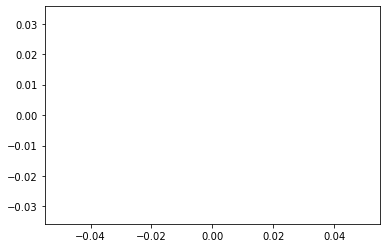

In [290]:
final = []
trials = 2
for d in tqdm(range(10, 21)):
    k = 5
    mins = []
    for n in range(1000, 7000, 100):
        sum_of_mins = 0
        for i in range(trials):
            while True:
                tot = k * n
                s = 2
                dist = 20
                spher = True
                cov_range = 2
                X, A = generate_data()
                X, A = center_gmm(X, A)

                mu = calculate_first_moment(X)
                Sigma = calculate_second_moment(X)
                s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)
                V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)
                A_est = perform_backwards_transformation(V_est, lamb)

                X_ = add_noise(X, 4000)
                tot = X_.shape[1]

                X_ = compute_fb(X_.T, .95, d)
                tot = X_.shape[1]

                mu_ = calculate_first_moment(X_.T)
                Sigma_ = calculate_second_moment(X_.T)
                s_est_, W_, X_whit_ = extract_information_from_second_moment(Sigma_, X_.T)
                V_est_, lamb_ = perform_tensor_power_method(X_whit_, W_, s_est_, mu_)
                A_est_ = perform_backwards_transformation(V_est_, lamb_)

                normal, yesfb, OG_fb = findMeans(k)
                if Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2)) < .4:
                    break
                
            sum_of_mins += Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2))
        mins.append(sum_of_mins/trials)
    final.append(mins)

In [ ]:
final = []
for d in tqdm(range(10, 31)):
    k = 5
    n = 5000
    mins = []
    sum_of_mins = 0
    trials = 1
    while True:
        tot = k * n
        s = 2
        dist = 20
        spher = True
        cov_range = 2
        X, A = generate_data()
        X, A = center_gmm(X, A)

        mu = calculate_first_moment(X)
        Sigma = calculate_second_moment(X)
        s_est, W, X_whit = extract_information_from_second_moment(Sigma, X)
        V_est, lamb = perform_tensor_power_method(X_whit, W, s_est, mu)
        A_est = perform_backwards_transformation(V_est, lamb)

        X_ = add_noise(X, 2000)
        tot = X_.shape[1]

        X_ = compute_fb(X_.T, .95, d)
        tot = X_.shape[1]

        mu_ = calculate_first_moment(X_.T)
        Sigma_ = calculate_second_moment(X_.T)
        s_est_, W_, X_whit_ = extract_information_from_second_moment(Sigma_, X_.T)
        V_est_, lamb_ = perform_tensor_power_method(X_whit_, W_, s_est_, mu_)
        A_est_ = perform_backwards_transformation(V_est_, lamb_)

        normal, yesfb, OG_fb = findMeans(k)
        if Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2)) < .4:
            break
                
    sum_of_mins += Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2))
    mins.append(sum_of_mins/trials)
    final.append(mins)

 76%|████████████████████████████████▊          | 16/21 [10:00<04:56, 59.22s/it]

In [333]:
print(f"Difference of A and FB: {Get_Min(normal/la.norm(OG_fb,2), yesfb/la.norm(yesfb,2))}")

Difference of A and FB: 0.04646322408249207


In [334]:
df2 = pd.DataFrame(final, index = [f"DIM-{i}" for i in range(10, 31)])

In [335]:
df2

,0
DIM-10,0.025786
DIM-11,0.059040
DIM-12,0.352738
DIM-13,0.076228
DIM-14,0.033418
DIM-15,0.204510
DIM-16,0.082453
DIM-17,0.062128
DIM-18,0.059243
DIM-19,0.056775


In [336]:
numpi = df2.to_numpy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


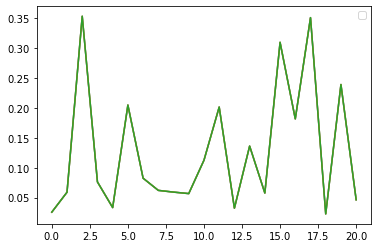

In [337]:
for i in range(0, 3):
    #plt.plot(np.arange(1000, 3000, 100), numpi[i], label=f'Dim={10 + i}')\
    plt.plot(numpi)
plt.legend()
plt.show()